In [36]:
import numpy as np
from numpy import unique
from numpy import where
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame
from sklearn.cluster import KMeans
from sklearn import datasets
import sklearn.cluster as skl_cluster
import sklearn.datasets.samples_generator as skl_smpl
from matplotlib import pyplot as plt

In [37]:
class KerKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, centroids=3, loop=50, cap=1e-3, random_state=None,
                 kernel="rbf", gamma=50.111, degree=3, df=1,
                 vals=None, backG=0):
        self.centroids = centroids
        self.loop = loop
        self.cap = cap
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.df = df
        self.vals = vals
        self.backG = backG
        


    def KernelComputation(self, X, Y=None):
        if callable(self.kernel):
            kernel_values = self.vals or {}
        else:
            kernel_values = {"gamma": self.gamma,
                      "degree": self.degree,
                      "df": self.df}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **kernel_values)

    def fit(self, X, y=None, wt=None):
        total = X.shape[0]
        
        K = self.KernelComputation(X)
        WithinS = wt if wt else np.ones(total)
        self.wt = WithinS
        
        self_rand = check_random_state(self.random_state)
        self.labels_ = self_rand.randint(self.centroids, size=total)
        dist = np.zeros((total, self.centroids))
        self.Distance_matrix_within = np.zeros(self.centroids)
        for it in range(self.loop):
            dist.fill(0)
            self.EqdDistance(K, dist, self.Distance_matrix_within,check=True)
            predicts1 = self.labels_
            self.labels_ = dist.argmin(axis=1)           
            pq = np.sum((self.labels_ - predicts1) == 0)
            if 1 - float(pq) / total < self.cap:
                if self.backG:
                    print ("Done", it + 1)
                break

        self.X_fit_ = X
        return self

    def EqdDistance(self, K, dist, within_distances, check):
        WithinS = self.wt
        for j in range(self.centroids):
            fk = self.labels_== j
            if np.sum(fk) == 0:
                raise ValueError("Data not found in cluster")
            A = WithinS[fk].sum()
            Asquare = A * A
            if check:
                Ksquare = K[fk][:, fk]  
                dist_j = np.sum(np.outer(WithinS[fk], WithinS[fk]) * Ksquare / Asquare)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(WithinS[fk] * K[:, fk], axis=1) / A
            
    @property
    def KernelPair(self):
        return self.kernel == "precomputed"
    
    def predict(self, X):
        A = self.KernelComputation(X, self.X_fit_)
        total = X.shape[0]
        XX = np.zeros((total, self.centroids))
        self.EqdDistance(A, XX, self.Distance_matrix_within,
                           check=False)
        return XX.argmin(axis=1)

In [38]:
if __name__ == '__main__':
    from sklearn.datasets import make_blobs
  

<function matplotlib.pyplot.show(*args, **kw)>

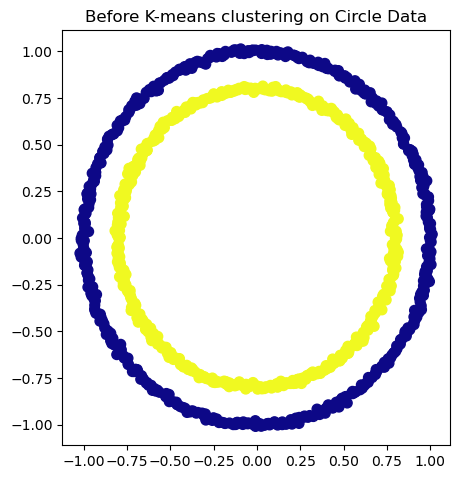

In [39]:
from sklearn.datasets import make_circles
nb_samples = 1000
X_circle, Y_circle = make_circles(n_samples=nb_samples, noise=0.01) 
#Before K means
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=Y_circle, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':100})
plt.title("Before K-means clustering on Circle Data")
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

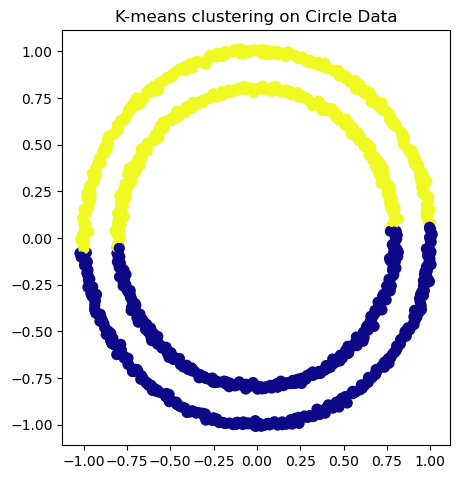

In [40]:
Kmean = skl_cluster.KMeans(n_clusters=2)
Kmean.fit(X_circle)
yhat_circle = Kmean.predict(X_circle)
#After K means
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=yhat_circle, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(7,5.5), 'figure.dpi':70})
plt.title("K-means clustering on Circle Data")
plt.show

In [41]:
#Kernel K means on Circle Data Set
km = KerKMeans(centroids=2, loop=1000, random_state=0, backG=1)

print (km.fit_predict(X_circle)[:150])
print (km.predict(X_circle[:150]))
yhat_circle_kernel=km.predict(X_circle)

Done 28
[0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 1]
[0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0
 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 1]


Text(0.5, 1.0, 'Kernel K-means clustering on Circle Data')

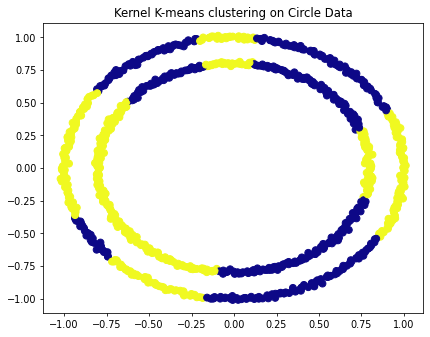

In [42]:
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=yhat_circle_kernel, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':100})
plt.title("Kernel K-means clustering on Circle Data")